# Self-driving car Nanodegree - Term 1

## Project 2: **Behavior Cloning** 
***
In this project, We built and trained a convolutional neural network for end-to-end driving in a simulator, using TensorFlow and Keras. We used optimization techniques such as regularization and dropout to generalize the network for driving on multiple tracks. The model will output a steering angle to an autonomous vehicle.

The goals / steps of this project are the following:
* Use the [simulator](https://github.com/udacity/self-driving-car-sim) to collect data of good driving behavior 
* Design, train and validate a model that predicts a steering angle from image data
* Use the model to drive the vehicle autonomously around the first track in the simulator. The vehicle should remain on the road for an entire loop around the track.
* Summarize the results with a written report

Author : [Tran Ly Vu](https://github.com/tranlyvu)

- [Github repo](https://github.com/tranlyvu/autonomous-vehicle-projects/tree/master/Behavior%20Cloning)
- [Notebook](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/notebook/Behavior%20Cloning.ipynb)
- [Python code](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/src/model.py)



### Files Submitted 

My project includes the following files:

```
- src/model.py containing the script to create and train the model
- drive.py for driving the car in autonomous mode
- model.h5 containing a trained convolution neural network
- notebook containing notebook
- run1.mp4 containing sample video of driving the car in autonomous mode using trained model 
```

Using the Udacity provided [simulator](https://github.com/udacity/self-driving-car-sim) and my drive.py file, I was able to test my model by driving autonomously around the track by executing:

```
python drive.py model.h5
```

Video of driving the car was generated by executing:

```
python drive.py model.h5 run1
python video.py run1 --fps 48
```

### Importing packages

In [1]:
import csv
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, Cropping2D, Lambda, Dropout
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from keras.layers.pooling import MaxPooling2D
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


---
### Dataset

I used training dataset provided by Udacity. I use all 3 positions of camera with correction of 0.25 , i.e addition of 0.25 to steering angle for left-positioned camera and substraction of 0.25 for right-positioned camera.

I could have self-produced ore data but due to time constraint, I only used Udacity dataset

Moreover, after unable to complete a whole lap, I follow advice from forum and decided to randomly choose camera to select from

The dataset is split into 20% of test set. Also, the training set is shuffled before training

#### Loading Dataset

In [2]:
'''Read data'''
image_path = '../../../data'
# row in log path is IMG/<name>
driving_log_path = '../../../data/driving_log.csv'

rows = []
with open(driving_log_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        rows.append(row)

---
### Model Architecture and Training Strategy

#### First Model

In [my first attempt](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/src/first_attempt.py), I used 9-layers network from [end to end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf) by NVIDIA 

1. Pre-processing pipeline
    - Data augmentation: Fliping the image horizontal (from function append_data)
    - Cropping the image
    - Normalization and Mean centering
2. NVIDIA original model
    
|Layer   |type    |output filter/neurons|
|--------|--------|--------|
|1       |conv    |24      |
|2       |conv    |36      |
|3       |conv    |48      |
|4       |conv    |64      |
|5       |conv    |64      |
|6       |flattern|1164    |
|7       |relu    |100     |
|8       |relu    |50      |
|9       |relu    |10      |
|10      |relu    |1       |

#### Second Attempt

However, I detected overfitting in my first attempt, and hence i tried to improved the mode in second model by using regulation, i.e dropout

1. Pre-processing pipeline
        - Data augmentation: Fliping the image horizontal (from function append_data)
        - Cropping the image
        - Normalization and Mean centering
2. Modified NVIDIA model
    
|Layer   |type    |output filter/neurons|
|--------|--------|--------|
|1       |conv    |24      |
|        |dropout |        |
|2       |conv    |36      |
|        |dropout |        |
|3       |conv    |48      |
|        |dropout |        |
|4       |conv    |64      |
|5       |conv    |64      |
|6       |flattern|1164    |
|7       |relu    |100     |
|8       |relu    |50      |
|9       |relu    |10      |
|10      |relu    |1       |

In [3]:
def append_data(col, images, measurement, steering_measurements):
    current_path = image_path + '/' + col.strip()
    
    image = cv2.imread(current_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(np.asarray(image))
    steering_measurements.append(measurement)
    
    # random flipping
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        image_flipped = np.fliplr(image)
        images.append(np.asarray(image_flipped))
        measurement_flipped = measurement * (-1)
        steering_measurements.append(measurement)
          

def images_and_measurements(sample):
    images = []
    steering_measurements = []
    for line in sample[0:]:
        measurement = float(line[3])
        ## random data
        camera = np.random.choice(['center', 'left', 'right'])
        if camera == 'center':
            col_center = line[0]
            append_data(col_center, images, measurement, steering_measurements)
        elif camera == 'left':
            col_left = line[1]
            append_data(col_left, images, measurement + 0.25, steering_measurements)
        else:
            col_right = line[2]
            append_data(col_right, images, measurement - 0.25, steering_measurements)
    return images, steering_measurements

def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]           
            images = []
            measurements = []
            for image, measurement in batch_samples:
                images.append(image)   
                measurements.append(measurement)
            # trim image to only see section with road
            x_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(x_train, y_train)


In [4]:
## Print total number of data , including augmentation
X_total, y_total = images_and_measurements(rows[1:])
print("Number of image is: ", len(X_total))
print("Number of measurement is: ", len(y_total))

Number of image is:  12140
Number of measurement is:  12140


#### Model Architecture Definition

In [5]:
model = Sequential()
#The cameras in the simulator capture 160 pixel by 320 pixel images., after cropping, it is 66x200
model.add(Cropping2D(cropping = ((74,20), (60,60)),input_shape=(160, 320, 3)))

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))  
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
'''Training: using MSE for regression'''
model.compile(loss='mse', optimizer='adam')

#### Model Training

For every time of training and parameter tunning, the model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.

At epoch of 10, the training and validation loss both went down fast and I think they would converge if I'd have increased number of epoch (graph is plotted in the [notebook](http://nbviewer.jupyter.org/gist/tranlyvu/671c4e258dcc5535f27e458e346c64e9). However, for this kind of regression problem, both trainning loss and accuracy do not seem to be useful, it is more important to test it on the [simulator](https://github.com/udacity/self-driving-car-sim) provided by Udacity. Therefore, I simply tune number of epoch until the vehicle run well on the track.

Final Model parameters:

```
- Optimizer: Adam optimizer, so the learning rate was not tuned manually 
- Epoch: 5
- Batch size: 32
```

In [6]:
print('Training model')            
samples = list(zip(X_total, y_total))          
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)
train_generator = generator(train_samples, batch_size = 32)
validation_generator = generator(validation_samples, batch_size = 32)

history_object = model.fit_generator(train_generator,
                                    samples_per_epoch = len(train_samples),
                                    validation_data = validation_generator,
                                    nb_val_samples = len(validation_samples),
                                    nb_epoch = 5, 
                                    verbose = 1)
print('Endding training, starting to save model')
model.save('../model.h5')

Training model
Epoch 1/5
9712/9712 [==============================] - 18s - loss: 0.0555 - val_loss: 0.0526
Epoch 2/5
9712/9712 [==============================] - 15s - loss: 0.0489 - val_loss: 0.0463
Epoch 3/5
9712/9712 [==============================] - 15s - loss: 0.0442 - val_loss: 0.0417
Epoch 4/5
9712/9712 [==============================] - 15s - loss: 0.0398 - val_loss: 0.0394
Epoch 5/5
9712/9712 [==============================] - 15s - loss: 0.0371 - val_loss: 0.0347
Endding training, starting to save model


dict_keys(['val_loss', 'loss'])


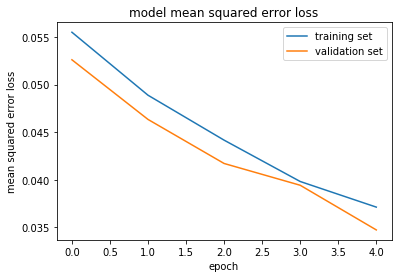

In [7]:
print(history_object.history.keys())
###plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

The project video is [here](https://youtu.be/TYh4y5VDFkE).